In [117]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# chrome://bookmarks/?q=xgboost

# Load and Prepare Data

In [118]:
df_incident = pd.read_csv('data/incident_dataset_trainTo151222.csv')
df_incident=df_incident.query("incident_response_minutes>=0")
df_incident=df_incident.dropna(how='all')
print(df_incident.info())
df_incident.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1925 entries, 0 to 1938
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   productype_name            1925 non-null   object
 1   brand_name                 1925 non-null   object
 2   sla_name                   1925 non-null   object
 3   warranty_months            1925 non-null   int64 
 4   incident_type_name         1925 non-null   object
 5   service_type_name          1925 non-null   object
 6   incident_response_minutes  1925 non-null   int64 
 7   severity_class             1925 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.4+ KB
None


,productype_name,brand_name,sla_name,warranty_months,incident_type_name,service_type_name,incident_response_minutes,severity_class
1934,Storage,NetApp,24x7 4Hrs Response Time,24,General Incident,Request,17,Minor
1935,Software,VMWare,24x7 4Hrs Response Time,11,General Incident,Incident,18,Minor
1936,Storage,NetApp,24x7 4Hrs Response Time,11,Configuration Change,Request,11,Cosmatic
1937,Storage,NetApp,24x7 6Hrs Resolution Time,54,OS / Firmware,Incident,17,Minor
1938,Storage,NetApp,24x7 6Hrs Resolution Time,54,General Incident,Request,44,Minor


# Split features and class

In [119]:
target_class='severity_class'
features=[ col for col in list(df_incident.columns) if  col!=class_target ]
X = df_incident.loc[:,features]
Y = df_incident.loc[:,target_class]

cate_features=[ col for col in features if  col not in ['warranty_months','incident_response_minutes'] ]
for cate_col in cate_features:
  X[cate_col]=X[cate_col].astype("category")

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1925 entries, 0 to 1938
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   productype_name            1925 non-null   category
 1   brand_name                 1925 non-null   category
 2   sla_name                   1925 non-null   category
 3   warranty_months            1925 non-null   int64   
 4   incident_type_name         1925 non-null   category
 5   service_type_name          1925 non-null   category
 6   incident_response_minutes  1925 non-null   int64   
dtypes: category(5), int64(2)
memory usage: 56.6 KB


In [120]:
print("=================================Features=============================")
print(X.tail())
print("=================================Target Class=============================")
print(Y[-5:])

=================================Features=============================
     productype_name brand_name                   sla_name  warranty_months  \
1934         Storage     NetApp    24x7 4Hrs Response Time               24   
1935        Software     VMWare    24x7 4Hrs Response Time               11   
1936         Storage     NetApp    24x7 4Hrs Response Time               11   
1937         Storage     NetApp  24x7 6Hrs Resolution Time               54   
1938         Storage     NetApp  24x7 6Hrs Resolution Time               54   

        incident_type_name service_type_name  incident_response_minutes  
1934      General Incident           Request                         17  
1935      General Incident          Incident                         18  
1936  Configuration Change           Request                         11  
1937         OS / Firmware          Incident                         17  
1938      General Incident           Request                         44  
==========

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_18660\3583843016.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(Y[-5:])


# Encode string class values as integers

In [121]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)
print(label_encoded_y[-5:])

[3 3 0 3 3]


# Split Train and Test Data

In [122]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(1540, 7) (385, 7)
(1540,) (385,)


# XGBoost Fit model no training data and Predict

In [123]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
model_xg = XGBClassifier(enable_categorical=True,tree_method="hist")

model_xg.fit(X_train, y_train)
print(model_xg)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [124]:
y_pred_xg = model.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBoost Accuracy: 76.10%


# Feature Important

In [129]:
import matplotlib.pyplot  as plt
feature_series=pd.Series(model_xg.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_series

service_type_name            0.652103
brand_name                   0.093279
incident_type_name           0.062424
sla_name                     0.057586
productype_name              0.055175
warranty_months              0.046776
incident_response_minutes    0.032656
dtype: float32

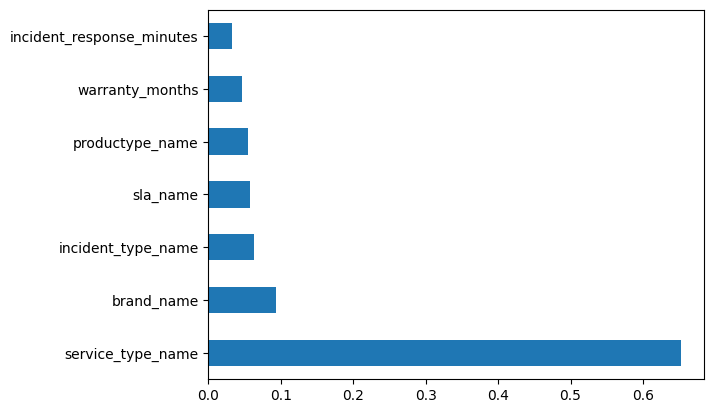

In [130]:
feature_series.plot(kind='barh')
plt.show()